# Ground Extraction Using Differential Morphological Profiles

This notebook will walk users through the process of extracting ground returns from point cloud data according to the work of Mongus [1]. The algorithm consists of three primary steps:

1. Initialization
2. Decomposition of grid and feature mapping
3. Point filtering

[1] D. Mongus, N. Lukac, and B. Zalik, “Ground and building extraction from LiDAR data based on differential morphological profiles and locally fitted surfaces,” ISPRS J. Photogramm. Remote Sens., vol. 93, no. January, pp. 145–156, 2014.

We need `astropy` for some convolution and interpolation, and it's not preloaded on our current Docker image, so we go ahead and install via `pip`.

In [1]:
!pip install astropy

Now proceed with our imports. There are seven packages that are required, two of which are only needed for visualization in the notebook. The five that are truly required for data processing are `astropy`, `numpy`, `pandas`, `pdal`, and `scipy`.

In [2]:
%matplotlib inline

from astropy.convolution import Gaussian2DKernel, convolve
from scipy import spatial, ndimage
from scipy.ndimage import morphology

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdal
import seaborn as sns

plt.set_cmap('plasma');

So that we can walk through the algorithm step-by-step, we start by executing a reader-only pipeline to read our point cloud input. In this case, we are using the `samp11` file from the ISPRS ground filtering test data suite.

In [3]:
json=u'''{
    "pipeline":[
        "/data/bare_earth_eval/isprs/converted/laz/samp11-utm.laz"
    ]
}'''
p = pdal.Pipeline(json)
p.validate()
p.execute()

38010

Let's read just the XYZ coordinates of the data into a `pandas` DataFrame.

In [4]:
df3D = pd.DataFrame(p.arrays[0], columns=['X','Y','Z'])

The algorithm requires the user to set four parameters. `S` indicates the depth of the scale space decomposition. `k` and `n` are used to define a per point threshold for determining ground/non-ground in the estimated surface. And `b` defines a tolerance for determining if a point is sufficiently close to the estimated surface to be labeled ground. For the ISPRS data, the authors have provided reasonable values for each of the parameters. The following should work well for `samp11`.

In [5]:
S = 30
k = 0.2
n = 0.3
b = 0.2

The target resolution of the estimated surface is set automatically as the inverse of the estimated density $D_L$

$$R_g=\frac{1.0}{D_L}$$

The density is defined as

$$D_L=\frac{N}{area}$$

where $N$ is the number of points (should really be last/only returns) and $area$ is estimated here by the bounding box. There can and should be more sophisticated methods for estimating density for actual data.

In [6]:
density = len(df3D) / (df3D.Y.ptp() * df3D.X.ptp())
hres = 1. / density
print "Point cloud density estimated as", density, "pts/m^2. Processing at", hres, "m resolution."

Point cloud density estimated as 0.937765534471 pts/m^2. Processing at 1.06636463299 m resolution.


## Initialization

Initilize the process by selecting points with lowest elevation at the target resolution.

We begin by computing bin edges ranging between XY min and max, spaced at a fixed resolution.

In [7]:
xi = np.ogrid[df3D.X.min():df3D.X.max():hres]
yi = np.ogrid[df3D.Y.min():df3D.Y.max():hres]

We use our bin edges to group each point by it's corresponding XY bin.

In [42]:
bins = df3D.groupby([np.digitize(df3D.X, xi), np.digitize(df3D.Y, yi)])

For each bin, find the minimum elevation, and record the XYZ coordinates at that point.

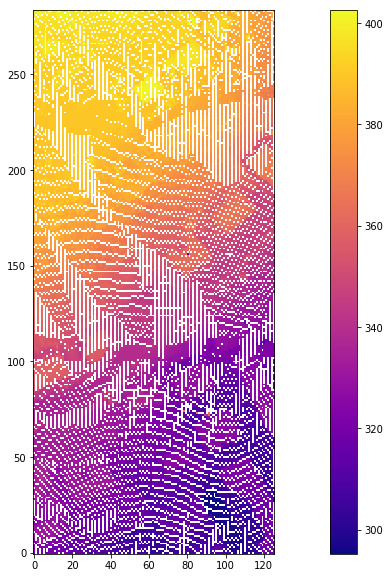

In [46]:
cz = np.empty((yi.size, xi.size))
cz.fill(np.nan)
for name, bin in bins:
    idx = bin.Z.idxmin()
    cz[name[1]-1, name[0]-1] = df3D.Z.loc[idx]
plt.figure(figsize=(20,10)); plt.imshow(cz, origin='lower'); plt.colorbar();

There is no Python package that I am aware of that will perform IDW to interpolate nans. IDW being defined as

$$g[p_n^*]=\frac{\sum_{p_n \in W^{p_n^*}}g[p_n]d_{p_n}^{-r}}{\sum_{p_n \in W^{p_n^*}}d_{p_n}^{-r}}$$

where $d_{p_n}$ is the Euclidean distance between $p_n^*$ and $p_n$ and $r=2$ defines the smoothness of the interpolation.

The following function should do the trick.

In [11]:
def idw(data):
    # Find indices of the ground returns, i.e., anything that is not a nan, and create a KD-tree.
    # We will search this tree when looking for nearest neighbors to perform the interpolation.
    valid = np.argwhere(~np.isnan(data))
    dfg = pd.DataFrame(valid, columns=['X','Y'])
    tree = spatial.cKDTree(dfg)
    
    # Now find indices of the non-ground returns, as indicated by nan values. We will interpolate
    # at these locations.
    nans = np.argwhere(np.isnan(data))
    dfng = pd.DataFrame(nans, columns=['X','Y'])
    
    for _, row in dfng.iterrows():
        # The paper says we should search a neighborhood, requiring at least 3 neighbors. For now,
        # we will just use 3 neighbors regardless.
        d, idx = tree.query([row.X, row.Y], k=3)
        
        # Convert to d^-2
        d = np.power(d, -2)
        
        # Get the elevations of the neighbors.
        v0 = data[dfg.iloc[idx[0]][0], dfg.iloc[idx[0]][1]]
        v1 = data[dfg.iloc[idx[1]][0], dfg.iloc[idx[1]][1]]
        v2 = data[dfg.iloc[idx[2]][0], dfg.iloc[idx[2]][1]]
        
        # Finally compute the IDW value.
        data[row.X, row.Y] = (v0*d[0] + v1*d[1] + v2*d[2])/(d[0]+d[1]+d[2])
        
    return data

For any remaining undefined cells, estimate via IDW.

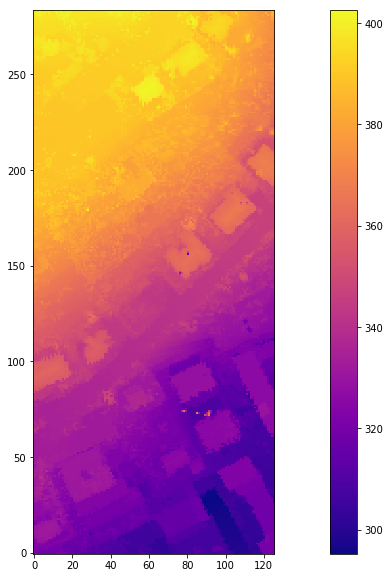

In [48]:
cz = idw(cz)
plt.figure(figsize=(20,10)); plt.imshow(cz, origin='lower'); plt.colorbar();

Replace those points that are more than 1.0m below the estimated surface (as determined by morphological opening/closing).

Begin by opening the control elevations using a diamond structuring element with radius 11.

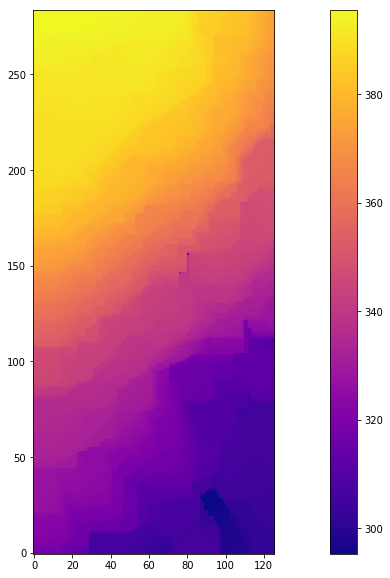

In [49]:
struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 11).astype(int)
opened = morphology.grey_opening(cz, structure=struct)
plt.figure(figsize=(20,10)); plt.imshow(opened, origin='lower'); plt.colorbar();

Close the control elevations using a diamond structuring element with radius 9.

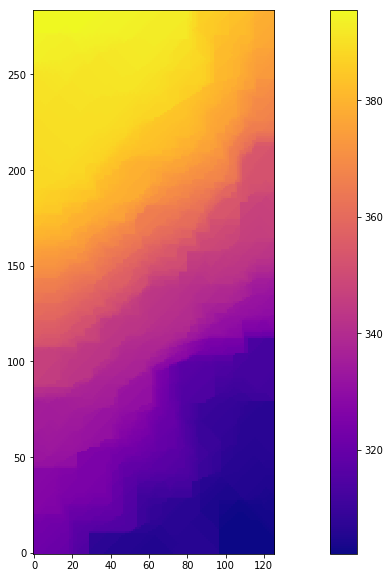

In [50]:
struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 9).astype(int)
closed = morphology.grey_closing(opened, structure=struct)
plt.figure(figsize=(20,10)); plt.imshow(closed, origin='lower'); plt.colorbar();

Record the locations where there appear to be low outliers, and replace with the morphologically altered surface.

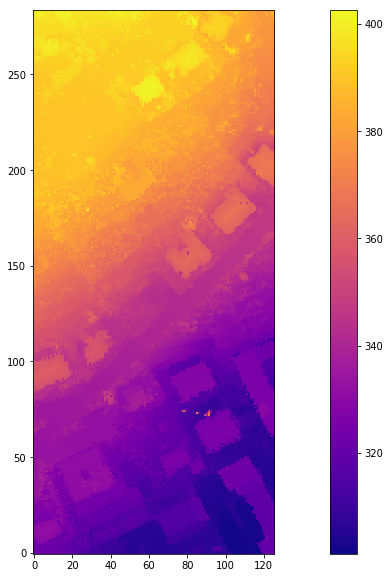

In [51]:
lowx, lowy = np.where((closed - cz) >= 1.0)
cz[lowx, lowy] = closed[lowx, lowy]
plt.figure(figsize=(20,10)); plt.imshow(cz, origin='lower'); plt.colorbar();

## Decomposition of grid and feature mapping

Convolve $g$ with a Gaussian kernel $G$ large enough to remove all contained non-ground features.

$$g^{\downarrow}=g*G$$

$g^{\downarrow}$ contains low-frequency terrain undulations, providing a rough approximation of the ground surface.

In [54]:
# The paper alludes to a "continuation" where stdev choice is discussed. Not sure I've come across it yet...
stdev = 14
G = Gaussian2DKernel(stdev)
low = convolve(np.pad(cz,2*stdev,'edge'), G)[2*stdev:-2*stdev,2*stdev:-2*stdev]

The high frequency information is the residual of $g$ and $g^{\downarrow}$, and contains the non-ground features.

$$g^{\uparrow}=g-g^{\downarrow}$$

Further processing is performed only on $g^{\uparrow}$.

In [16]:
high = cz - low

The initialized surface, as well as the low and high pass frequency bands are shown below.

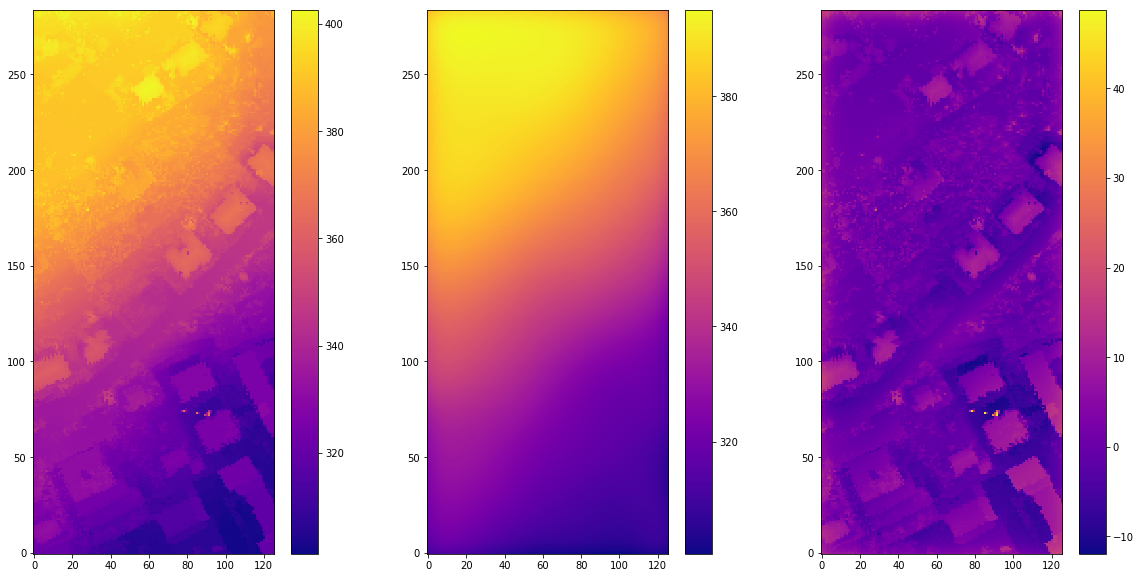

In [17]:
plt.figure(figsize=(20, 10));
plt.subplot(1,3,1); plt.imshow(cz, origin='lower'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(low, origin='lower'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(high, origin='lower'); plt.colorbar();

Multiscale decomposition achieved by using a granulometry of morphological openings $\gamma_{w_{s_{i}}}(g^{\uparrow})$

In [18]:
granulometry = []
for scale in xrange(1, S+1):
    struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), scale).astype(int)
    o = morphology.grey_opening(high, structure=struct)
    granulometry.append(o)

A top-hat scale-space, known as DMPs

$$\Delta(g^{\uparrow})=\{\gamma_{w_{s_{i-1}}}(g^{\uparrow})-\gamma_{w_{s_{i}}}(g^{\uparrow})\}$$

where $i\in[1,I]$ and $I=cardinality(s)-1$.

In [19]:
out = []
for i in xrange(1, len(granulometry)):
    out.append(granulometry[i-1]-granulometry[i])

- $g^{\prime}$ registers the largest response from $\Delta(g^{\uparrow})$ at each point $p$

$$g^{\prime}[p]=\bigvee_{i\in[1,I]}\Delta(g^{\uparrow})[p][i]$$

- $g^*$ describes the smallest scale at which the largest response is registered

$$g^*[p]=\bigwedge_{i\in[1,I]}s_i \big| \Delta(g^{\uparrow})[p][i]=g^{\prime}[p]$$

- $g^+$ is the sum of all responses up to and including the largest response

$$g^+[p]=\sum_{i \le g^*[p]}\Delta(g^{\uparrow})[p][i]$$

In [41]:
gprime = np.maximum.reduce(out)
xs, ys = out[0].shape
gstar = np.zeros((xs,ys))
gplus = np.zeros((xs,ys))
for ii in xrange(0,xs):
    for jj in xrange(0,ys):
        for kk in xrange(0,len(out)):
            if out[kk][ii,jj] < gprime[ii,jj]:
                gplus[ii,jj] += out[kk][ii,jj]
            if out[kk][ii,jj] == gprime[ii,jj]:
                gplus[ii,jj] += out[kk][ii,jj]
                gstar[ii,jj] = kk
                break

$g^{\prime}$, $g^*$, and $g^+$ are plotted below.

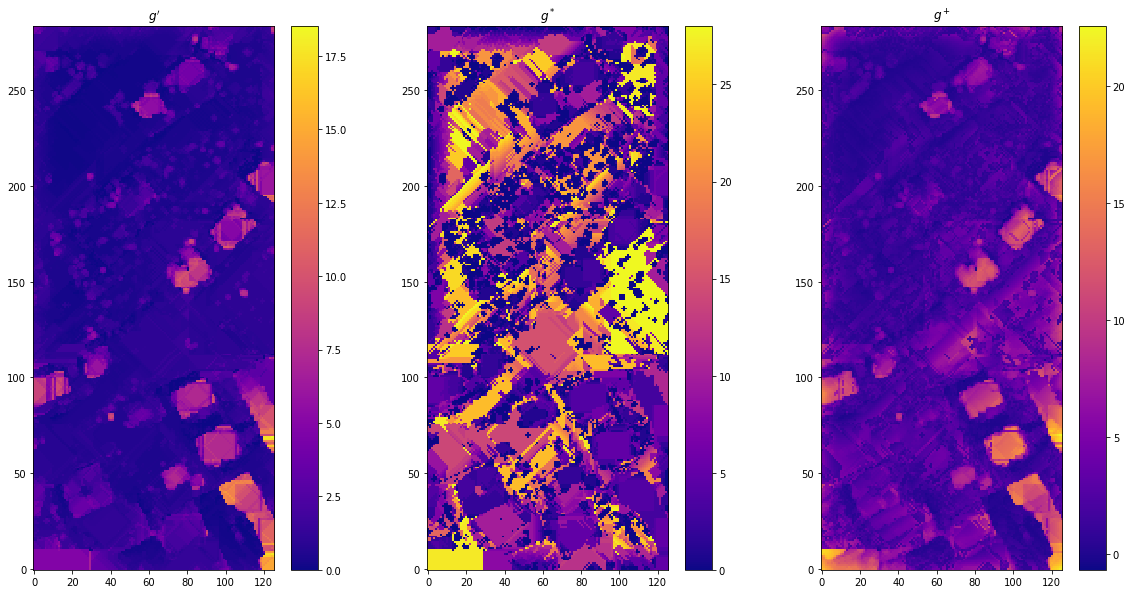

In [59]:
plt.figure(figsize=(20, 10));
plt.subplot(1,3,1); plt.imshow(gprime, origin='lower'); plt.colorbar(); plt.title('$g^{\prime}$')
plt.subplot(1,3,2); plt.imshow(gstar, origin='lower'); plt.colorbar(); plt.title('$g^*$')
plt.subplot(1,3,3); plt.imshow(gplus, origin='lower'); plt.colorbar(); plt.title('$g^+$')

## Point filtering

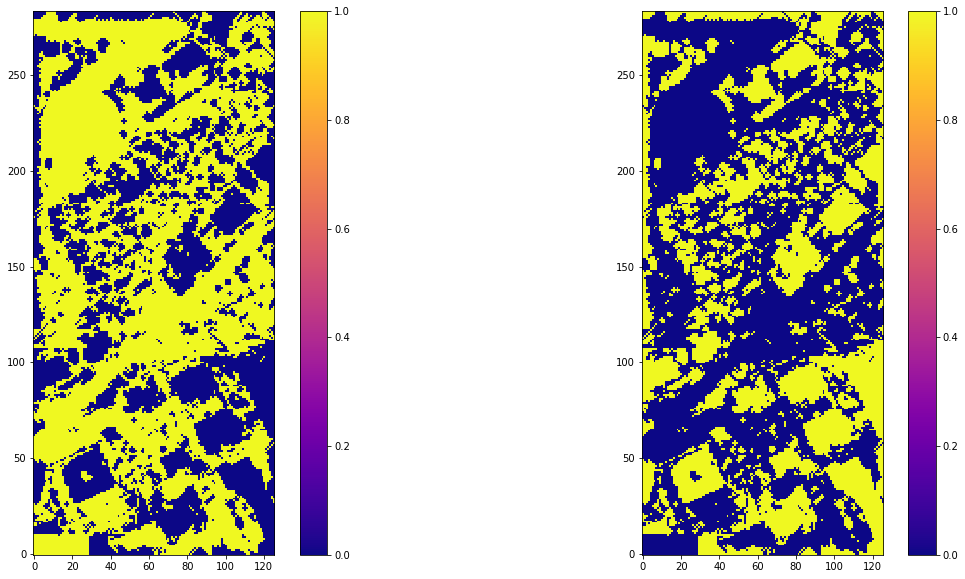

In [61]:
T = k * gstar + n
Sg = gprime < T
plt.figure(figsize=(20, 10));
plt.subplot(1,2,1); plt.imshow(Sg, origin='lower'); plt.colorbar();
plt.subplot(1,2,2); plt.imshow(gprime >= T, origin='lower'); plt.colorbar();

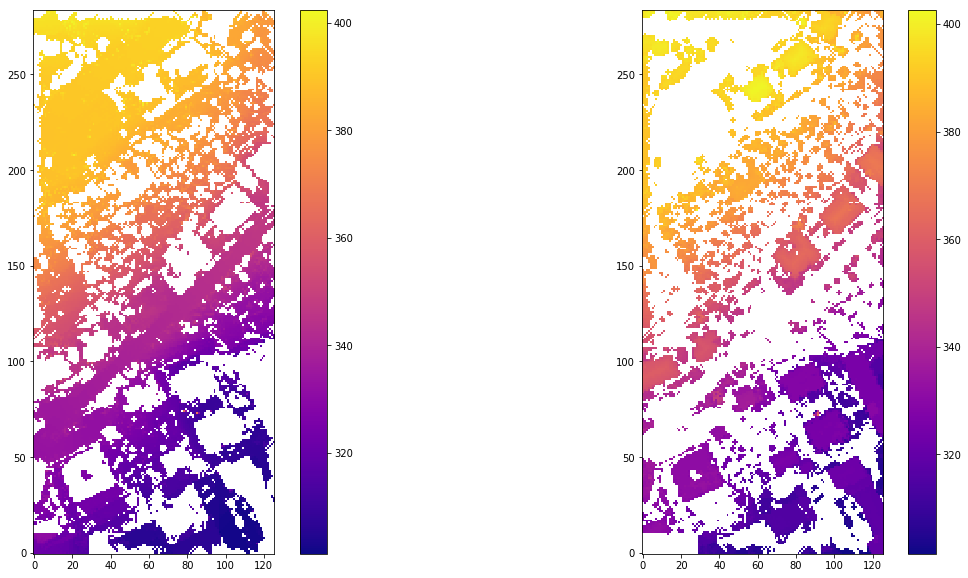

In [63]:
F = cz.copy()
F[np.where(Sg==0)] = np.nan
plt.figure(figsize=(20,10));
plt.subplot(1,2,1); plt.imshow(F, origin='lower'); plt.colorbar();
nonGround = cz.copy()
nonGround[np.where(Sg==1)] = np.nan
plt.subplot(1,2,2); plt.imshow(nonGround, origin='lower'); plt.colorbar();

In [26]:
G = idw(F)

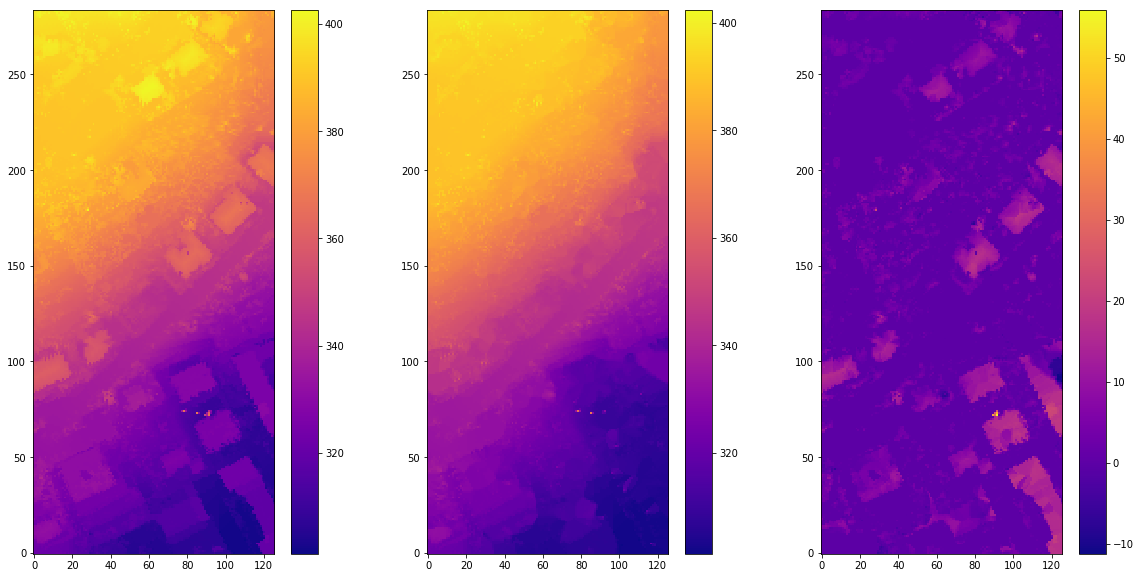

In [27]:
plt.figure(figsize=(20,10));
plt.subplot(1,3,1); plt.imshow(cz, origin='lower'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(G, origin='lower'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(cz-G, origin='lower'); plt.colorbar();

In [28]:
struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 1).astype(int)
gradDTM = morphology.grey_dilation(G, structure=struct)

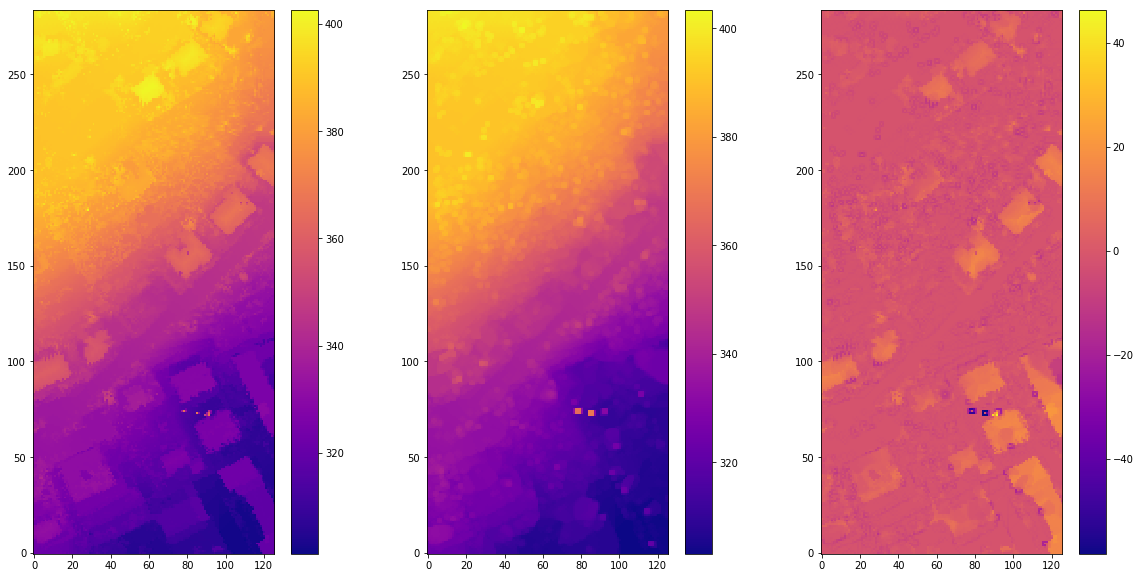

In [29]:
plt.figure(figsize=(20,10));
plt.subplot(1,3,1); plt.imshow(cz, origin='lower'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(gradDTM, origin='lower'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(cz-(gradDTM+b), origin='lower'); plt.colorbar();

In [30]:
xi = np.ogrid[df3D.X.min():df3D.X.max():hres]
yi = np.ogrid[df3D.Y.min():df3D.Y.max():hres]
ground = []
nonground = []
for i in range(0,len(df3D)):
    xbin = np.digitize(df3D.X[i], xi)
    ybin = np.digitize(df3D.Y[i], yi)
    if df3D.Z[i] >= gradDTM[ybin-1,xbin-1]+b:
        nonground.append(i)
    else:
        ground.append(i)

In [31]:
print "Detected", len(ground), "ground and", len(nonground), "non-ground points"

Detected 29060 ground and 8950 non-ground points


In [32]:
g = df3D.iloc[ground]
ng = df3D.iloc[nonground]

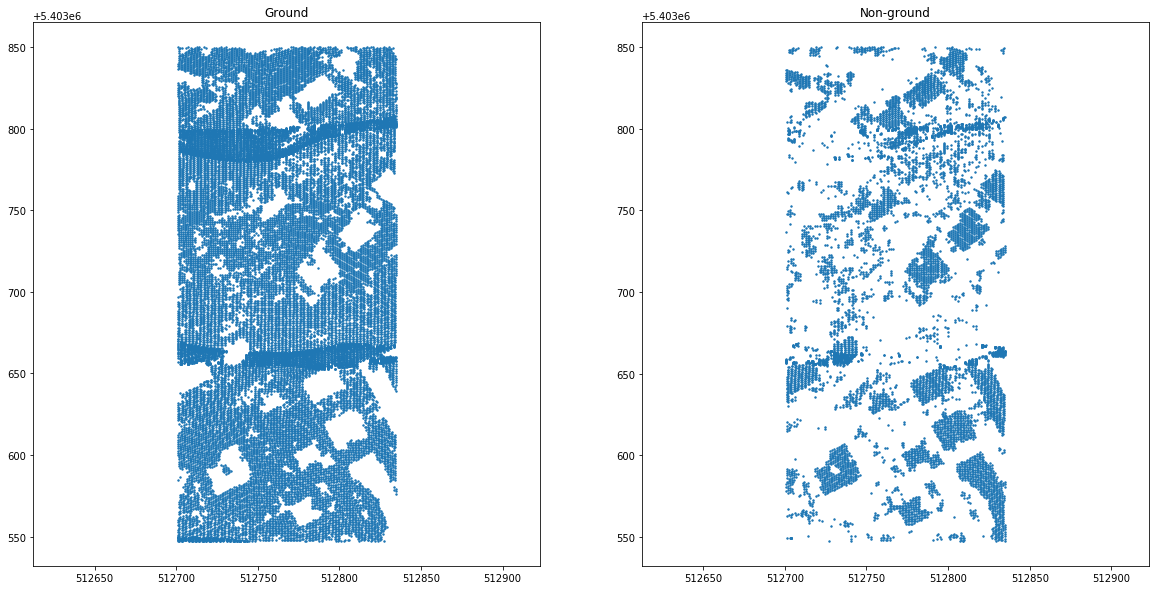

In [33]:
plt.figure(figsize=(20,10));
plt.subplot(1,2,1); plt.scatter(g.X, g.Y, s=2); plt.title('Ground'); plt.axis('equal');
plt.subplot(1,2,2); plt.scatter(ng.X, ng.Y, s=2); plt.title('Non-ground'); plt.axis('equal');

In [ ]:
json=u'''{
    "pipeline":[
        "/data/bare_earth_eval/isprs/converted/laz/samp11-utm.laz",
        {
            "type":"filters.python",
            "module":"anything",
            "function":"filter",
            "source":"from astropy.convolution import Gaussian2DKernel, convolve
from scipy import spatial, ndimage
from scipy.ndimage import morphology

import numpy as np
import pandas as pd

S = 30
k = 0.2
n = 0.3
b = 0.2

def idw(data):
    valid = np.argwhere(~np.isnan(data))
    nans = np.argwhere(np.isnan(data))
    dfg = pd.DataFrame(valid, columns=['X','Y'])
    dfng = pd.DataFrame(nans, columns=['X','Y'])
    tree = spatial.cKDTree(dfg)
    for _, row in dfng.iterrows():
        d, idx = tree.query([row.X, row.Y], k=3)
        d = np.power(d,-2)
        v0 = data[dfg.iloc[idx[0]][0], dfg.iloc[idx[0]][1]]
        v1 = data[dfg.iloc[idx[1]][0], dfg.iloc[idx[1]][1]]
        v2 = data[dfg.iloc[idx[2]][0], dfg.iloc[idx[2]][1]]
        data[row.X, row.Y] = (v0*d[0] + v1*d[1] + v2*d[2])/(d[0]+d[1]+d[2])
    return data

def filter(ins, outs):
    # Use the X, Y, and Z dimension data to classify points as ground or
    # non-ground.

    # Begin by getting the Classification dimension and setting all values to 1
    # for unclassified.
    cls = ins['Classification']
    cls.fill(1)
    
    df3D = pd.DataFrame({'X': ins['X'], 'Y': ins['Y'], 'Z': ins['Z']})
    density = len(df3D) / (df3D.Y.ptp() * df3D.X.ptp())
    hres = 1. / density
    
    # Initilize the process by selecting points with lowest elevation at the target resolution.
    # Replace those points that are more than 1.0m below the estimated surface (as determined by
    # morphological opening/closing.

    # Next, we compute bin edges ranging between XY min and max, spaced at a fixed resolution.
    xi = np.ogrid[df3D.X.min():df3D.X.max():hres]
    yi = np.ogrid[df3D.Y.min():df3D.Y.max():hres]

    # We can effectively group all incoming points by their XY bin.
    groups = df3D.groupby([np.digitize(df3D.X, xi), np.digitize(df3D.Y, yi)])

    # Record coords of point with minimum Z for each XY bin.
    cz = np.empty((yi.size, xi.size))
    cz.fill(np.nan)
    for name, group in groups:
        idx = group.Z.idxmin()
        cz[name[1]-1, name[0]-1] = df3D.Z.loc[idx]

    # For any remaining undefined cells, estimate via IDW
    cz = idw(cz)

    # Open the control elevations using a diamond structuring element with radius 11.
    struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 11).astype(int)
    opened = morphology.grey_opening(cz, structure=struct)

    # Close the control elevations using a diamond structuring element with radius 9.
    struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 9).astype(int)
    closed = morphology.grey_closing(opened, structure=struct)

    # Record the locations where there appear to be low outliers.
    lowx, lowy = np.where((closed - cz) >= 1.0)

    # Replace low outliers with the morphologically altered surface.
    cz[lowx, lowy] = closed[lowx, lowy]
    stdev = 14
    G = Gaussian2DKernel(stdev)
    low = convolve(np.pad(cz,2*stdev,'edge'), G)[2*stdev:-2*stdev,2*stdev:-2*stdev]
    high = cz - low
    
    # Multiscale decomposition achieved by using a granulometry of morphological openings.
    granulometry = []
    for scale in xrange(1, S+1):
        struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), scale).astype(int)
        o = morphology.grey_opening(high, structure=struct)
        granulometry.append(o)
    
    # A top-hat scale-space, known as DMPs
    out = []
    for i in xrange(1, len(granulometry)):
        out.append(granulometry[i-1]-granulometry[i])
    
    # gprime registers the largest responses from the DMP
    # gstar describes the smallest scales at which the largest response is registered
    # gplus is the sum of all responses registered before and including the largest response
    xs, ys = out[0].shape
    gprime = np.maximum.reduce(out)
    gstar = np.zeros((xs,ys))
    gplus = np.zeros((xs,ys))
    for ii in xrange(0,xs):
        for jj in xrange(0,ys):
            for kk in xrange(0,len(out)):
                if out[kk][ii,jj] < gprime[ii,jj]:
                    gplus[ii,jj] += out[kk][ii,jj]
                if out[kk][ii,jj] == gprime[ii,jj]:
                    gplus[ii,jj] += out[kk][ii,jj]
                    gstar[ii,jj] = kk
                    break
    
    T = k * gstar + n
    Sg = gprime < T
    F=cz.copy()
    F[np.where(Sg==0)] = np.nan
    G=idw(F)
    struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 1).astype(int)
    gradDTM = morphology.grey_dilation(G, structure=struct)
    xi = np.ogrid[df3D.X.min():df3D.X.max():hres]
    yi = np.ogrid[df3D.Y.min():df3D.Y.max():hres]
    ground = []
    nonground = []
    for i in range(0,len(df3D)):
        xbin = np.digitize(df3D.X[i], xi)
        ybin = np.digitize(df3D.Y[i], yi)
        if df3D.Z[i] < gradDTM[ybin-1,xbin-1]+b:
            ground.append(i)
        
    cls[ground] = 2

    # Set the output dimension and return.
    outs['Classification'] = cls
    return True"
        },
        "/data/bare_earth_eval/isprs/converted/laz/samp11-utm-dmp.las"
    ]
}'''
p = pdal.Pipeline(json)
p.validate()
p.execute()